# Library import

In [47]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.cluster import DBSCAN


In [173]:
raw_data=pd.read_csv("./data_SNat/CDSA_EssaimSaintes_2004-2005_lat-lon.txt",sep='\t')


## Data preprocessing

In [174]:
datetime.fromisoformat('1900-01-01')+timedelta(seconds=3345210427.94)

datetime.datetime(2006, 1, 2, 17, 7, 7, 940000)

In [175]:
def transform_todatetime(data):
    data['sec']= data['sec'].apply(lambda x :datetime.fromisoformat('1900-01-01')+timedelta(seconds=x))
    return data

In [177]:
df1=raw_data.copy()
df1=transform_todatetime(df1)
df1['date']=df1['sec'].dt.date


### Clustering with DBSCAN , high min_dist

In [268]:
clusters = DBSCAN(eps = 0.03, min_samples=20)
clusters.fit(df1[['lat', 'lon']])
df1['labels'] = [str(e) for e in clusters.labels_]
import plotly.express as px



fig = px.scatter_mapbox(df1, lat="lat", lon="lon", color='labels')

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"t":0,"l":0,"b":0})
fig.show()

## CLustering with DBSCAN low distance_min

In [269]:
df=raw_data.copy()
df=transform_todatetime(df)
df['date']=df['sec'].dt.date
clusters = DBSCAN(eps = 0.02, min_samples=20)
clusters.fit(df[['lat', 'lon']])
df['labels'] = [str(e) for e in clusters.labels_]
import plotly.express as px



fig = px.scatter_mapbox(df, lat="lat", lon="lon", color='labels')

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"t":0,"l":0,"b":0})
fig.show()


## Clustering with ST_DBSCAN

In [181]:
from st_dbscan import ST_DBSCAN
df2=raw_data.copy()
df2['sec']=(df2['sec'] -df2['sec'].min())/(df2['sec'].max()-df2['sec'].min())
df2['lat']=(df2['lat'] -df2['lat'].min())/(df2['lat'].max()-df2['lat'].min())
df2['lon']=(df2['lon'] -df2['lon'].min())/(df2['lon'].max()-df2['lon'].min())

st_db=ST_DBSCAN(eps1=0.02,eps2=0.5,min_samples=20)
st_db.fit(df2[['sec','lat','lon']])


In [182]:
print(st_db.labels)
df2['labels'] = [str(e) for e in st_db.labels]


[ 0  0 -1 ... -1 -1  2]


In [183]:
#df1 = df[df.labels != '-1']
test_df=pd.merge(df2[['labels']],raw_data,right_index=True,left_index=True)
#test_df=transform_todatetime(test_df)


In [267]:
fig = px.scatter_mapbox(test_df, lat="lat", lon="lon", color='labels')

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"t":0,"l":0,"b":0})
fig.show()

## Exploiting differents results obtained previously

In [211]:
def preprocessing(data):
    data=data.loc[data['labels']!='-1'] #removing alll noise points
    return data

def visualize_all(data):
    temp = data.loc[data.groupby('labels')['mag'].idxmax()]
    return temp.index.tolist()

## Time Clustering

In [254]:
def select_cluster(label,data):
    cluster_df=data.loc[(data['labels']==label)]
    cluster_df.sort_values(by=['sec'])
    return cluster_df



def get_mainshock(data):
    id_mainshock=data['mag'].idxmax()
    date1=data.loc[id_mainshock][5]
    main_df=data.drop(index=id_mainshock)
    print(id_mainshock)
    return main_df,date1


    
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))


def get_sismic_seq(cluster,date1):
    closest_date= nearest(cluster['date'],date1)
    list_index=[]
    while (date1 -timedelta(days=3) < closest_date < date1+timedelta(days=3) ):
        new_indexes=cluster.loc[cluster['date']==closest_date].index.values
        list_index.extend(new_indexes)
        cluster=cluster.drop(index=new_indexes)
        date1=closest_date

        closest_date=nearest(cluster['date'],date1)
    return cluster,list_index

df=preprocessing(df)



2227


## Loi OmoriUtsu

### Every clusters from DBSCAN low dist_min

##### Label 0

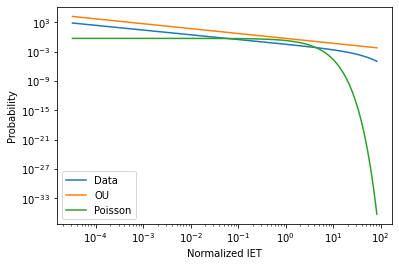

4.196573267720559


In [258]:
time = np.array(df.loc[df['labels']=="0"]['sec'])
Ms_pourcent = GraphInterEventTime(time)
print(Ms_pourcent)

##### Label 1

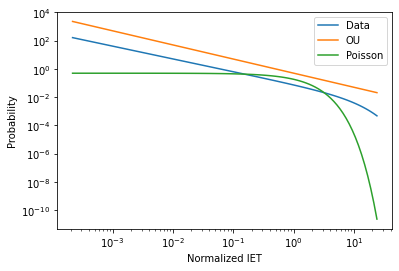

11.109862682759955


In [259]:
time = np.array(df.loc[df['labels']=="1"]['sec'])
Ms_pourcent = GraphInterEventTime(time)
print(Ms_pourcent)

###### Label 2

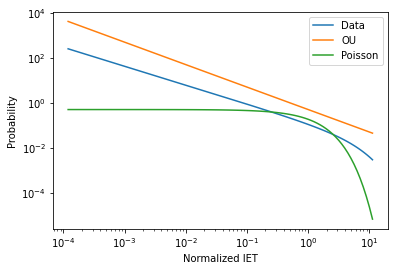

18.213061937383173


In [246]:
time =np.array(df.loc[df['labels']=="2"]['sec'])
Ms_pourcent = GraphInterEventTime(time)
print(Ms_pourcent)

On remarque que pour les **Saintes**, un clustering spatial semble dejà dégager des séquences sysmiques suivant **la Loi OmoriUtsu**.
Ce qui parait assez logique, car les données ne couvrent qu'un faible intervalle temporelle, on ne retrouve donc pas de chevauchement entre séquence
sysmique.



Ensuite au sein même de ces séquences sysmiques ont va essayer d'en extraire des sous-séquences sysmiques qui suivent aussi la loi d'OmoriUtsu 

2227


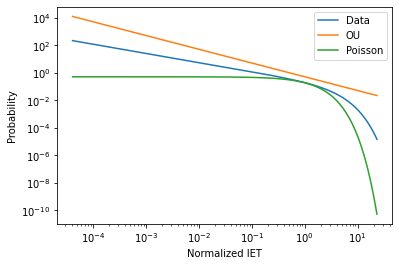

37.54848834969354


In [266]:
df3=df.copy()  
cluster_df=select_cluster("0",df3)
cluster_df,date1=get_mainshock(cluster_df)
clust,indexes=get_sismic_seq(cluster_df,date1)

time =np.array(df.loc[indexes]['sec'])
Ms_pourcent = GraphInterEventTime(time)
print(Ms_pourcent)

In [253]:
import pandas as pd
import math
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt


def GraphInterEventTime(time):

    time.sort()
    Norm_IET = np.diff(time) * np.size(time) / (time.max() - time.min())

    beta = Norm_IET.var() / Norm_IET.mean()
    delta = 4.4 * (1 - 4 * (Norm_IET.mean() / beta - 0.5) ** 2)
    Ms_pourcent = Norm_IET.mean() / beta * 100 + delta

    Tmp = Norm_IET[Norm_IET> 0]
    sample_Norm_IE = np.linspace(Tmp.min(), Tmp.max(), 100)
    density_Norm_IET = stats.gaussian_kde(Norm_IET)

    gamma = Norm_IET.mean() / beta
    C = 1 / (math.gamma(gamma) * beta ** gamma)
    proba = C * sample_Norm_IE ** (gamma - 1) * np.exp(-sample_Norm_IE / beta)

    x_log = np.logspace(np.log10(Tmp.min()), np.log10(Tmp.max()), 100)

    fig, ax = plt.subplots()
    ax.plot(sample_Norm_IE, proba, label='Data')
    ax.plot(x_log, 1 / (2 * x_log), label='OU')
    ax.plot(x_log, np.exp(-1 * x_log) / 2, label='Poisson')
    ax.set_xscale('log')
    ax.set_xlabel('Normalized IET')
    ax.set_yscale('log')
    ax.set_ylabel('Probability')
    ax.legend()
    plt.show()


    if Ms_pourcent <= 100:
        return Ms_pourcent
    elif (1 / beta) * 100 <= 100:
        return 1 / beta

In [ ]:
from pyproj import Proj, transform
inProj = Proj(init='epsg:2154')
outProj = Proj(init='epsg:4326')
dff['p0'],dff['p1']= transform(inProj,outProj,dff['p0'],dff['p1'])
dff.to_csv("mayotte_2018.csv")